# Pneumonia Detection from Chest Xray Transfer Learning ResNet50

In [ ]:
import os
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

seed = 232
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)


Mounted at /content/drive


In [ ]:
input_path = '/content/drive/MyDrive/chest_xray/chest_xray/'

In [ ]:
for _set in ['train', 'val', 'test']:
    n_normal = len(os.listdir(input_path + _set + '/NORMAL'))
    n_infect = len(os.listdir(input_path + _set + '/PNEUMONIA'))
    print('Set: {}, normal images: {}, pneumonia images: {}'.format(_set, n_normal, n_infect))

Set: train, normal images: 1342, pneumonia images: 3876
Set: val, normal images: 9, pneumonia images: 9
Set: test, normal images: 234, pneumonia images: 390


In [ ]:
def process_data(img_dims, batch_size):
    train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)
    test_val_datagen = ImageDataGenerator(rescale=1./255)
    
    train_gen = train_datagen.flow_from_directory(
    directory=input_path+'train', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)

    test_gen = test_val_datagen.flow_from_directory(
    directory=input_path+'test', 
    target_size=(img_dims, img_dims), 
    batch_size=batch_size, 
    class_mode='binary', 
    shuffle=True)
    
    test_data = []
    test_labels = []
    
    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(input_path + 'test' + cond)):
            img = plt.imread(input_path+'test'+cond+img)
            img = cv2.resize(img, (img_dims, img_dims))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond=='/NORMAL/':
                label = 0
            elif cond=='/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)
        
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return train_gen, test_gen, test_data, test_labels

In [ ]:
img_dims = 150
epochs = 10
batch_size = 32

train_gen, test_gen, test_data, test_labels = process_data(img_dims, batch_size)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
test_data.shape

(624, 150, 150, 3)

In [ ]:
inputs = Input(shape=(img_dims, img_dims, 3))

from tensorflow.keras.applications.resnet50 import ResNet50
base_model = ResNet50(weights='imagenet',include_top=False,input_shape=(img_dims, img_dims, 3))
x = base_model.output

x = Dropout(0.5)(x)
from keras.layers import GlobalAveragePooling2D
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = BatchNormalization()(x)
output = Dense(1,activation = 'sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')

94781440/94765736 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 156, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 75, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 75, 64)   256         ['conv1_conv[0][0]']         

In [ ]:
hist = model.fit_generator(
           train_gen, steps_per_epoch=train_gen.samples // batch_size, 
           epochs=epochs, validation_data=test_gen, 
           validation_steps=test_gen.samples // batch_size, callbacks=[checkpoint, lr_reduce])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


Epoch 1/10
163/163 [==============================] - 1805s 11s/step - loss: 0.3119 - accuracy: 0.8946 - val_loss: 5.0800 - val_accuracy: 0.6234 - lr: 0.0010
Epoch 2/10
163/163 [==============================] - 1792s 11s/step - loss: 0.1828 - accuracy: 0.9383 - val_loss: 2.7816 - val_accuracy: 0.6266 - lr: 0.0010
Epoch 3/10
163/163 [==============================] - ETA: 0s - loss: 0.1542 - accuracy: 0.9431 
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 1861s 11s/step - loss: 0.1542 - accuracy: 0.9431 - val_loss: 2.5606 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 4/10
163/163 [==============================] - 1853s 11s/step - loss: 0.1106 - accuracy: 0.9626 - val_loss: 2.5298 - val_accuracy: 0.6250 - lr: 3.0000e-04
Epoch 5/10
163/163 [==============================] - ETA: 0s - loss: 0.0903 - accuracy: 0.9676 
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
163/163 [====================

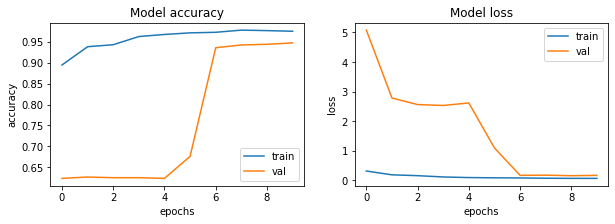

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

preds = model.predict(test_data)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((hist.history['accuracy'][-1])*100, 2)))

CONFUSION MATRIX ------------------
[[201  33]
 [  5 385]]

TEST METRICS ----------------------
Accuracy: 93.91025641025641%
Precision: 92.10526315789474%
Recall: 98.71794871794873%
F1-score: 95.29702970297029

TRAIN METRIC ----------------------
Train acc: 97.53


In [ ]:
import seaborn as sn

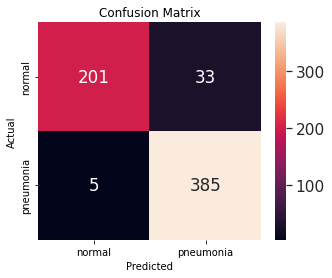

In [ ]:
df_cm = pd.DataFrame(cm, index = ('normal', 'pneumonia'), columns = ('normal', 'pneumonia'))
plt.figure(figsize = (5,4))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()